# 02 — Optimization with PyTorch (4×4 Sudoku)

This notebook builds on **Chapter 01** (tensor basics + differentiable constraints).  
Here we focus on **how** an optimizer turns those constraints into an actual Sudoku solution.

> Key idea: we do **not** train a neural network.  
> We directly optimize a **tensor of logits** whose softmax becomes the probability tensor **P**.

---
## 2.1 Recap: The Constraint Landscape
A valid Sudoku solution is defined by constraints:
- **Row uniqueness**: each digit appears exactly once per row
- **Column uniqueness**: each digit appears exactly once per column
- **Block uniqueness**: each digit appears exactly once per block
- **Givens**: given cells must keep the correct digit
- Optional: **entropy** to encourage confident (nearly one-hot) predictions


In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

torch.set_printoptions(precision=4, sci_mode=False)
device = torch.device("cpu")


---
## 2.2 What Does It Mean to Optimize **P**?
We represent a 4×4 Sudoku as a tensor of probabilities:

- **P** has shape **(4, 4, 4)**
- `P[r, c, k]` is the probability that cell `(r, c)` contains digit `k+1`.

During optimization, we do **not** update `P` directly.  
Instead we optimize **logits** `Z` and compute:

\[ P = \text{softmax}(Z / T) \]

where `T` is a temperature (optionally annealed over time).


---
## 2.3 Parameterization: Logits → Softmax → Probabilities

Why optimize logits?
- logits are unconstrained real numbers
- softmax turns them into a valid probability distribution per cell
- probabilities stay well-behaved during gradient updates


## Help Functions
- `probs_from_logits` applies a softmax over the digit dimension `k`,
  ensuring that the probabilities for each cell sum to 1.
- `argmax` selects the most likely digit per cell and is used only for
  visualization, not during optimization. argmax returns the first occurrence of the maximum value.

In [3]:
def probs_from_logits(Z, T=1.0):
    # Z: (4,4,4) logits
    # returns P: (4,4,4) probs
    return F.softmax(Z / T, dim=2)

def pretty_grid_from_probs(P):
    # takes argmax per cell, returns digits 1..4
    return P.argmax(dim=2) + 1

def loss_dict(P, givens_mask, givens_target, weights):
    w_row, w_col, w_blk, w_giv, w_ent = weights
    L_row, L_col, L_blk, L_giv, L_ent = sudoku_losses(P, givens_mask, givens_target)
    L_total = w_row*L_row + w_col*L_col + w_blk*L_blk + w_giv*L_giv + w_ent*L_ent
    return {
        "L_row": L_row,
        "L_col": L_col,
        "L_blk": L_blk,
        "L_giv": L_giv,
        "L_ent": L_ent,
        "L_total": L_total,
    }

def print_losses(tag, d):
    # .item() macht aus tensor(...) einen float, ohne grad_fn-Anzeige
    print(
    tag,
    {k: f"{v.detach().cpu().item():.3f}" for k, v in d.items()},
    "\n"
)




---
## 2.4 The Optimizer (Adam) — High-Level View

Each iteration does:
1. logits `Z` → probabilities `P`
2. compute constraint losses
3. sum into `L_total`
4. backpropagate gradients w.r.t. `Z`
5. `optimizer.step()` updates `Z`

Next, we implement the constraint losses.


In [4]:
def sudoku_losses(P, givens_mask, givens_target, eps=1e-8):
    """
    P: (4,4,4) probabilities over digits 1..4 (k dimension last)
    givens_mask: (4,4) bool, True where a clue is given
    givens_target: (4,4) long, values in [0..3] for digit indices (digit-1)
    """
    # Row uniqueness: for each row i and digit k, sum over columns j should be 1
    row_sum = P.sum(dim=1)                 # (4,4)
    L_row = ((row_sum - 1.0) ** 2).sum()

    # Column uniqueness: for each col j and digit k, sum over rows i should be 1
    col_sum = P.sum(dim=0)                 # (4,4)
    L_col = ((col_sum - 1.0) ** 2).sum()

    # Block uniqueness: 2×2 blocks
    L_blk = 0.0
    for br in (0, 2):
        for bc in (0, 2):
            blk = P[br:br+2, bc:bc+2, :]   # (2,2,4)
            blk_sum = blk.sum(dim=(0,1))   # (4,)
            L_blk = L_blk + ((blk_sum - 1.0) ** 2).sum()

    # Givens loss: encourage given cells to keep probability 1 at the given digit
    # pick probabilities at given positions
    given_probs = P[givens_mask]                       # (num_givens, 4)
    given_targets = givens_target[givens_mask]         # (num_givens,)
    # negative log-likelihood (cross entropy) on givens
    L_giv = F.nll_loss((given_probs + eps).log(), given_targets, reduction='sum')

    # Entropy: encourage low entropy (more confident predictions)
    ent = -(P * (P + eps).log()).sum(dim=2)            # (4,4)
    L_ent = ent.sum()

    return L_row, L_col, L_blk, L_giv, L_ent


---
## 2.5 One Optimization Step (Concrete!)
We demonstrate a single optimizer step on an **almost solved** 4×4 Sudoku.

Sudoku Puzzle:
```
[1, 2, 3, 4]
[3, 4, 1, 2]
[2, 1, 4, 3]
[4, 3, 0, 1]
```

Only one cell [3,2| is unknown. This makes it easy to see how the optimizer shifts
probabilities away from inconsistent digits and towards the only consistent digit.

If we translate the Sudoku Puzzle to `P`, we get the following cube:

<img src="images/02_P_Cube_4x4x4.jpg" alt="4×4×4 Sudoku as a probability tensor cube" width="200"/>

- Gray cubes represent a probability of `0.25` (uniform uncertainty)
- Beige cubes represent `0.0`
- Black cubes represent given digits with value `1.0`



In [5]:
# Almost solved 4×4 Sudoku (0 = unknown)
# Digits are 1..4
grid = torch.tensor([
    [1, 2, 3, 4],
    [3, 4, 1, 2],
    [2, 1, 4, 3],
    [4, 3, 0, 1],
], dtype=torch.long)

# Build givens mask + targets (targets are digit-1 in [0..3])
givens_mask = grid != 0
givens_target = (grid-1).clamp(min=0)

grid, givens_mask, givens_target


(tensor([[1, 2, 3, 4],
         [3, 4, 1, 2],
         [2, 1, 4, 3],
         [4, 3, 0, 1]]),
 tensor([[ True,  True,  True,  True],
         [ True,  True,  True,  True],
         [ True,  True,  True,  True],
         [ True,  True, False,  True]]),
 tensor([[0, 1, 2, 3],
         [2, 3, 0, 1],
         [1, 0, 3, 2],
         [3, 2, 0, 0]]))

In [6]:
# Initialize logits Z.
# For given cells, we initialize logits such that the correct digit is strongly preferred.
# For the unknown cell, logits start at 0 -> uniform probabilities after softmax.

Z = torch.zeros((4,4,4), dtype=torch.float32, device=device)

# Strongly bias given cells (large positive logit for the correct digit, negative for others)
high = 6.0
low = -6.0
for r in range(4):
    for c in range(4):
        if givens_mask[r,c]:
            k = int(givens_target[r,c].item())  # 0..3
            Z[r,c,:] = low
            Z[r,c,k] = high

# Check probabilities at the unknown cell (3,2)
P0 = probs_from_logits(Z, T=1.0)
Z, P0, pretty_grid_from_probs(P0)


(tensor([[[ 6., -6., -6., -6.],
          [-6.,  6., -6., -6.],
          [-6., -6.,  6., -6.],
          [-6., -6., -6.,  6.]],
 
         [[-6., -6.,  6., -6.],
          [-6., -6., -6.,  6.],
          [ 6., -6., -6., -6.],
          [-6.,  6., -6., -6.]],
 
         [[-6.,  6., -6., -6.],
          [ 6., -6., -6., -6.],
          [-6., -6., -6.,  6.],
          [-6., -6.,  6., -6.]],
 
         [[-6., -6., -6.,  6.],
          [-6., -6.,  6., -6.],
          [ 0.,  0.,  0.,  0.],
          [ 6., -6., -6., -6.]]]),
 tensor([[[    1.0000,     0.0000,     0.0000,     0.0000],
          [    0.0000,     1.0000,     0.0000,     0.0000],
          [    0.0000,     0.0000,     1.0000,     0.0000],
          [    0.0000,     0.0000,     0.0000,     1.0000]],
 
         [[    0.0000,     0.0000,     1.0000,     0.0000],
          [    0.0000,     0.0000,     0.0000,     1.0000],
          [    1.0000,     0.0000,     0.0000,     0.0000],
          [    0.0000,     1.0000,     0.0000,     0.

In [7]:
# Compute losses BEFORE the step
L_row, L_col, L_blk, L_giv, L_ent = sudoku_losses(P0, givens_mask, givens_target)
L_row, L_col, L_blk, L_giv, L_ent


(tensor(0.7500),
 tensor(0.7500),
 tensor(0.7500),
 tensor(0.0003),
 tensor(1.3899))

In [8]:
# One optimizer step
weights = (1.0, 1.0, 1.2, 2.0, 0.01)

Z_step = Z.clone().detach().requires_grad_(True)
opt = torch.optim.Adam([Z_step], lr=0.3)

# BEFORE step
P = probs_from_logits(Z_step, T=1.0)
print ("P-before", P,"\n", pretty_grid_from_probs(P), "\n")
d0 = loss_dict(P, givens_mask, givens_target, weights)
print_losses("P  (before)", d0)

# update
opt.zero_grad()
d0["L_total"].backward()
opt.step()

# AFTER step
P1 = probs_from_logits(Z_step, T=1.0)  # detach nicht nötig fürs Anzeigen
d1 = loss_dict(P1, givens_mask, givens_target, weights)
print ("P1-after", P1,"\n", pretty_grid_from_probs(P1), "\n")
print_losses("P1 (after) ", d1)

# Deltas
print("Δ (after - before):",
      {k: float((d1[k]-d0[k]).detach().cpu().item()) for k in d0.keys()})


P-before tensor([[[    1.0000,     0.0000,     0.0000,     0.0000],
         [    0.0000,     1.0000,     0.0000,     0.0000],
         [    0.0000,     0.0000,     1.0000,     0.0000],
         [    0.0000,     0.0000,     0.0000,     1.0000]],

        [[    0.0000,     0.0000,     1.0000,     0.0000],
         [    0.0000,     0.0000,     0.0000,     1.0000],
         [    1.0000,     0.0000,     0.0000,     0.0000],
         [    0.0000,     1.0000,     0.0000,     0.0000]],

        [[    0.0000,     1.0000,     0.0000,     0.0000],
         [    1.0000,     0.0000,     0.0000,     0.0000],
         [    0.0000,     0.0000,     0.0000,     1.0000],
         [    0.0000,     0.0000,     1.0000,     0.0000]],

        [[    0.0000,     0.0000,     0.0000,     1.0000],
         [    0.0000,     0.0000,     1.0000,     0.0000],
         [    0.2500,     0.2500,     0.2500,     0.2500],
         [    1.0000,     0.0000,     0.0000,     0.0000]]],
       grad_fn=<SoftmaxBackward0>) 
 te

### For Loop
You will oberserve that cell P(3,2) converges quickly from 

`[0.25,0.25,0.25]`
to
`[0.0080, 0.9761, 0.0080, 0.0080]`



In [9]:
weights = (1.0, 1.0, 1.2, 2.0, 0.01)

Z_step = Z.clone().detach().requires_grad_(True)
opt = torch.optim.Adam([Z_step], lr=0.3)

unknown_rc = (3, 2)

# Baseline (Iteration 0)
P0 = probs_from_logits(Z_step, T=1.0)
d_base = loss_dict(P0, givens_mask, givens_target, weights)

print("Iter 0")
print("Grid:\n", pretty_grid_from_probs(P0))
print("Unknown cell probs:", P0[unknown_rc[0], unknown_rc[1], :].detach().cpu())
print_losses("Losses", d_base)
print()

# Loop
steps = 10
print_every = 1  # z.B. 1 = jede Iteration, 5 = jede 5te

for it in range(1, steps + 1):
    P = probs_from_logits(Z_step, T=1.0)
    d = loss_dict(P, givens_mask, givens_target, weights)

    opt.zero_grad()
    d["L_total"].backward()
    opt.step()

    # Anzeige nach dem Update
    P_after = probs_from_logits(Z_step, T=1.0)
    d_after = loss_dict(P_after, givens_mask, givens_target, weights)

    if it % print_every == 0:
        print(f"Iter {it}")
        print("Grid:\n", pretty_grid_from_probs(P_after))
        print("Unknown cell probs:", P_after[unknown_rc[0], unknown_rc[1], :].detach().cpu())

        # hübsch: before/after/delta zur Baseline
        deltas = {k: float((d_after[k] - d_base[k]).detach().cpu().item()) for k in d_base.keys()}
        print_losses("Losses", d_after)
        print("Δ vs Iter0:", {k: f"{v:+.3f}" for k, v in deltas.items()})
        print()


Iter 0
Grid:
 tensor([[1, 2, 3, 4],
        [3, 4, 1, 2],
        [2, 1, 4, 3],
        [4, 3, 1, 1]])
Unknown cell probs: tensor([0.2500, 0.2500, 0.2500, 0.2500])
Losses {'L_row': '0.750', 'L_col': '0.750', 'L_blk': '0.750', 'L_giv': '0.000', 'L_ent': '1.390', 'L_total': '2.414'} 


Iter 1
Grid:
 tensor([[1, 2, 3, 4],
        [3, 4, 1, 2],
        [2, 1, 4, 3],
        [4, 3, 2, 1]])
Unknown cell probs: tensor([0.2074, 0.3779, 0.2074, 0.2074])
Losses {'L_row': '0.516', 'L_col': '0.516', 'L_blk': '0.516', 'L_giv': '0.000', 'L_ent': '1.349', 'L_total': '1.665'} 

Δ vs Iter0: {'L_row': '-0.234', 'L_col': '-0.234', 'L_blk': '-0.234', 'L_giv': '-0.000', 'L_ent': '-0.041', 'L_total': '-0.749'}

Iter 2
Grid:
 tensor([[1, 2, 3, 4],
        [3, 4, 1, 2],
        [2, 1, 4, 3],
        [4, 3, 2, 1]])
Unknown cell probs: tensor([0.1582, 0.5255, 0.1582, 0.1582])
Losses {'L_row': '0.300', 'L_col': '0.300', 'L_blk': '0.300', 'L_giv': '0.000', 'L_ent': '1.215', 'L_total': '0.973'} 

Δ vs Iter0: {'L_r

**Interpretation**  
The optimizer does not “know” Sudoku. It follows gradients created by the constraints.  
Digits that violate row/column/block consistency are pushed down, while the consistent digit is pushed up.

In a less constrained puzzle, this process takes many iterations and benefits from entropy + temperature control.


---
## 2.6 Entropy and Temperature Annealing

- **Entropy loss** encourages probabilities to become confident (close to one-hot).
- **Temperature** controls how sharp softmax outputs are:
  - high `T` → softer probabilities (more exploration)
  - low `T` → sharper probabilities (more exploitation)

A common strategy is to start with a higher temperature and slowly decrease it.


In [10]:
def optimize_sudoku(Z_init, givens_mask, givens_target, steps=300, lr=0.2,
                   T_start=1.5, T_end=0.6, w_row=1.0, w_col=1.0, w_blk=1.2, w_giv=2.0, w_ent=0.01):
    Z = Z_init.clone().detach().requires_grad_(True)
    opt = torch.optim.Adam([Z], lr=lr)

    hist = {
        "L_total": [], "L_row": [], "L_col": [], "L_blk": [], "L_giv": [], "L_ent": [], "T": []
    }

    for t in range(steps):
        # linear temperature schedule
        alpha = t / max(1, steps-1)
        T = (1-alpha)*T_start + alpha*T_end

        P = probs_from_logits(Z, T=T)
        L_row, L_col, L_blk, L_giv, L_ent = sudoku_losses(P, givens_mask, givens_target)
        L_total = w_row*L_row + w_col*L_col + w_blk*L_blk + w_giv*L_giv + w_ent*L_ent

        opt.zero_grad()
        L_total.backward()
        opt.step()

        hist["L_total"].append(float(L_total.detach().cpu()))
        hist["L_row"].append(float(L_row.detach().cpu()))
        hist["L_col"].append(float(L_col.detach().cpu()))
        hist["L_blk"].append(float(L_blk.detach().cpu()))
        hist["L_giv"].append(float(L_giv.detach().cpu()))
        hist["L_ent"].append(float(L_ent.detach().cpu()))
        hist["T"].append(float(T))

    return Z.detach(), hist


In [11]:
# Run the full optimization on the same "almost solved" puzzle (converges quickly)
Z_final, hist = optimize_sudoku(Z, givens_mask, givens_target, steps=80, lr=0.3, T_start=1.2, T_end=0.7)
P_final = probs_from_logits(Z_final, T=0.7)
pretty_grid_from_probs(P_final), P_final[unknown_rc[0], unknown_rc[1], :]

(tensor([[1, 2, 3, 4],
         [3, 4, 1, 2],
         [2, 1, 4, 3],
         [4, 3, 2, 1]]),
 tensor([    0.0000,     1.0000,     0.0000,     0.0000]))

---
## 2.7 Convergence Behavior and Failure Modes

Typical issues when scaling to harder puzzles:
- **Local minima**: the optimizer gets stuck in a partially consistent state
- **Learning rate too high**: oscillations or instability
- **Weights poorly tuned**: one constraint dominates and blocks progress
- **Entropy too strong too early**: forces premature, wrong decisions

Below we visualize convergence (loss over iterations) for this simple example.


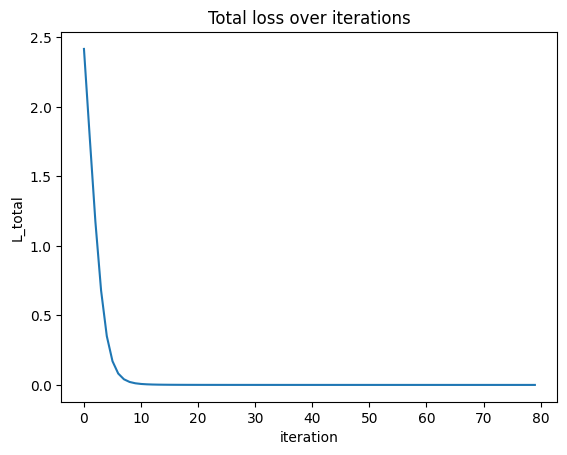

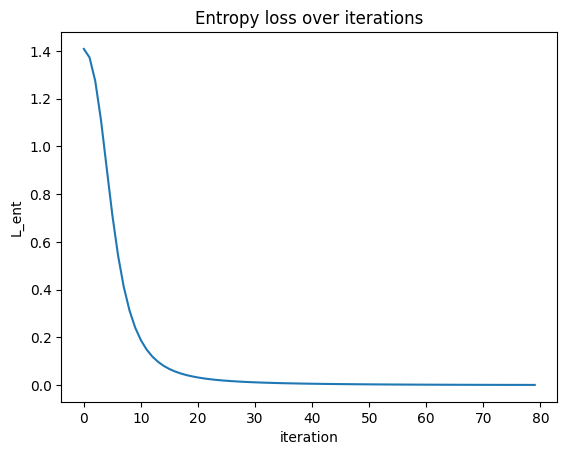

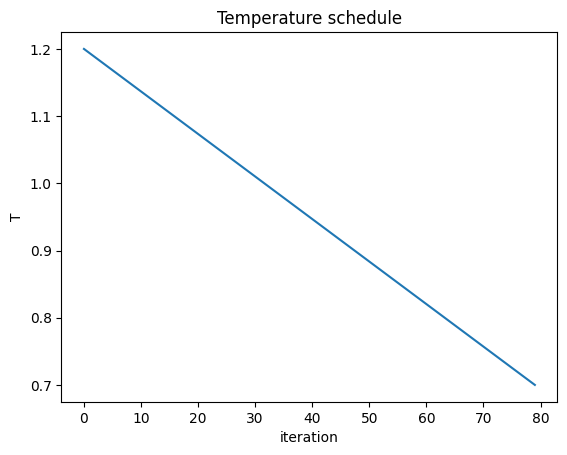

In [12]:
plt.figure()
plt.plot(hist["L_total"])
plt.title("Total loss over iterations")
plt.xlabel("iteration")
plt.ylabel("L_total")
plt.show()

plt.figure()
plt.plot(hist["L_ent"])
plt.title("Entropy loss over iterations")
plt.xlabel("iteration")
plt.ylabel("L_ent")
plt.show()

plt.figure()
plt.plot(hist["T"])
plt.title("Temperature schedule")
plt.xlabel("iteration")
plt.ylabel("T")
plt.show()


### 3 More Unkowns
In this example we will select more unknowns in order to show how the optimizer works for a mutlidimenional field.
We select as Puzzle follwing grid
```
[0, 0, 0, 4]
[3, 4, 1, 2]
[0, 1, 0, 3]
[4, 3, 2, 1]
```


In [18]:
# Almost solved 4×4 Sudoku (0 = unknown)
# Digits are 1..4
grid = torch.tensor([
    [0, 0, 0, 4],
    [3, 0, 1, 0],
    [0, 1, 0, 3],
    [4, 3, 2, 1],
], dtype=torch.long)

# Build givens mask + targets (targets are digit-1 in [0..3])
givens_mask = grid != 0
givens_target = (grid-1).clamp(min=0)

grid, givens_mask, givens_target


(tensor([[0, 0, 0, 4],
         [3, 0, 1, 0],
         [0, 1, 0, 3],
         [4, 3, 2, 1]]),
 tensor([[False, False, False,  True],
         [ True, False,  True, False],
         [False,  True, False,  True],
         [ True,  True,  True,  True]]),
 tensor([[0, 0, 0, 3],
         [2, 0, 0, 0],
         [0, 0, 0, 2],
         [3, 2, 1, 0]]))

In [19]:
# Initialize logits Z.
# For given cells, we initialize logits such that the correct digit is strongly preferred.
# For the unknown cell, logits start at 0 -> uniform probabilities after softmax.

Z = torch.zeros((4,4,4), dtype=torch.float32, device=device)

# Strongly bias given cells (large positive logit for the correct digit, negative for others)
high = 6.0
low = -6.0
for r in range(4):
    for c in range(4):
        if givens_mask[r,c]:
            k = int(givens_target[r,c].item())  # 0..3
            Z[r,c,:] = low
            Z[r,c,k] = high

# Check probabilities at the unknown cell (3,2)
P0 = probs_from_logits(Z, T=1.0)
Z, P0, pretty_grid_from_probs(P0)

(tensor([[[ 0.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  0.],
          [-6., -6., -6.,  6.]],
 
         [[-6., -6.,  6., -6.],
          [ 0.,  0.,  0.,  0.],
          [ 6., -6., -6., -6.],
          [ 0.,  0.,  0.,  0.]],
 
         [[ 0.,  0.,  0.,  0.],
          [ 6., -6., -6., -6.],
          [ 0.,  0.,  0.,  0.],
          [-6., -6.,  6., -6.]],
 
         [[-6., -6., -6.,  6.],
          [-6., -6.,  6., -6.],
          [-6.,  6., -6., -6.],
          [ 6., -6., -6., -6.]]]),
 tensor([[[    0.2500,     0.2500,     0.2500,     0.2500],
          [    0.2500,     0.2500,     0.2500,     0.2500],
          [    0.2500,     0.2500,     0.2500,     0.2500],
          [    0.0000,     0.0000,     0.0000,     1.0000]],
 
         [[    0.0000,     0.0000,     1.0000,     0.0000],
          [    0.2500,     0.2500,     0.2500,     0.2500],
          [    1.0000,     0.0000,     0.0000,     0.0000],
          [    0.2500,     0.2500,     0.2500,     0.

In [30]:
weights = (1.0, 1.0, 1.2, 2.0, 0.01)

Z_step = Z.clone().detach().requires_grad_(True)
opt = torch.optim.Adam([Z_step], lr=0.3)

unknown_rc = (0, 0)

# Baseline (Iteration 0)
P0 = probs_from_logits(Z_step, T=1.0)
d_base = loss_dict(P0, givens_mask, givens_target, weights)

print("Iter 0")
print("Grid:\n", pretty_grid_from_probs(P0))
print("Unknown cell probs:", P0[unknown_rc[0], unknown_rc[1], :].detach().cpu())
print_losses("Losses", d_base)
print()

# Loop
steps = 10
print_every = 1  # z.B. 1 = jede Iteration, 5 = jede 5te

for it in range(1, steps + 1):
    P = probs_from_logits(Z_step, T=1.0)
    d = loss_dict(P, givens_mask, givens_target, weights)

    opt.zero_grad()
    d["L_total"].backward()
    opt.step()

    # Anzeige nach dem Update
    P_after = probs_from_logits(Z_step, T=1.0)
    d_after = loss_dict(P_after, givens_mask, givens_target, weights)

    if it % print_every == 0:
        print(f"Iter {it}")
        print("P_afer\n", P_after)
        print("max probs per cell:\n", P_after.max(dim=2).values)
        print("Grid:\n", pretty_grid_from_probs(P_after))
        print("Unknown cell probs:", P_after[unknown_rc[0], unknown_rc[1], :].detach().cpu())

        # hübsch: before/after/delta zur Baseline
        deltas = {k: float((d_after[k] - d_base[k]).detach().cpu().item()) for k in d_base.keys()}
        print_losses("Losses", d_after)
        print("Δ vs Iter0:", {k: f"{v:+.3f}" for k, v in deltas.items()})
        print()

Iter 0
Grid:
 tensor([[1, 1, 1, 4],
        [3, 1, 1, 1],
        [1, 1, 1, 3],
        [4, 3, 2, 1]])
Unknown cell probs: tensor([0.2500, 0.2500, 0.2500, 0.2500])
Losses {'L_row': '2.750', 'L_col': '3.750', 'L_blk': '3.250', 'L_giv': '0.000', 'L_ent': '9.706', 'L_total': '10.497'} 


Iter 1
P_afer
 tensor([[[    0.3228,     0.3228,     0.1772,     0.1772],
         [    0.2818,     0.2818,     0.1546,     0.2818],
         [    0.1772,     0.3228,     0.3228,     0.1772],
         [    0.0000,     0.0000,     0.0000,     1.0000]],

        [[    0.0000,     0.0000,     1.0000,     0.0000],
         [    0.1772,     0.3228,     0.1772,     0.3228],
         [    1.0000,     0.0000,     0.0000,     0.0000],
         [    0.2074,     0.3779,     0.2074,     0.2074]],

        [[    0.2074,     0.3779,     0.2074,     0.2074],
         [    1.0000,     0.0000,     0.0000,     0.0000],
         [    0.2074,     0.2074,     0.2074,     0.3779],
         [    0.0000,     0.0000,     1.0000, 

In [26]:
# Run the full optimization on the same "almost solved" puzzle (converges quickly)
Z_final, hist = optimize_sudoku(Z, givens_mask, givens_target, steps=20, lr=0.1, T_start=1.2, T_end=0.7)
P_final = probs_from_logits(Z_final, T=0.7)
pretty_grid_from_probs(P_final), P_final[unknown_rc[0], unknown_rc[1], :]

(tensor([[1, 2, 3, 4],
         [3, 4, 1, 2],
         [2, 1, 4, 3],
         [4, 3, 2, 1]]),
 tensor([0.9097, 0.0751, 0.0082, 0.0071]))

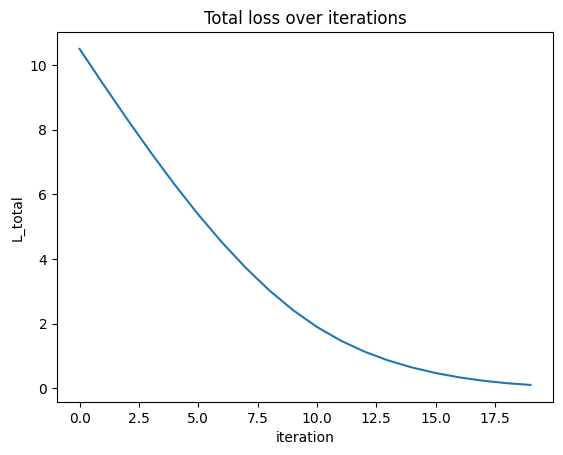

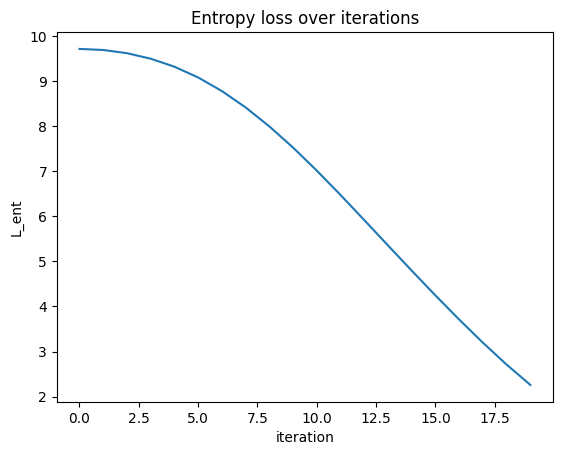

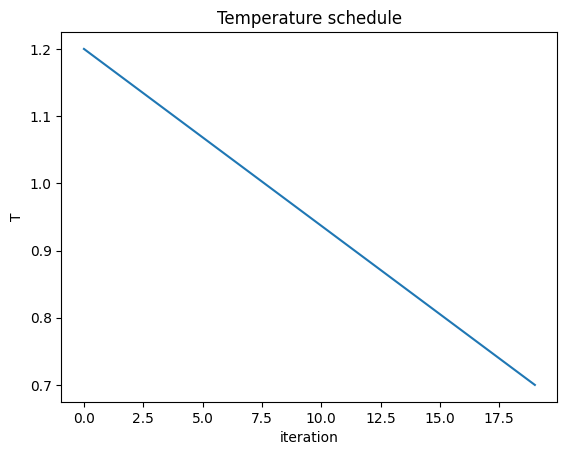

In [27]:
plt.figure()
plt.plot(hist["L_total"])
plt.title("Total loss over iterations")
plt.xlabel("iteration")
plt.ylabel("L_total")
plt.show()

plt.figure()
plt.plot(hist["L_ent"])
plt.title("Entropy loss over iterations")
plt.xlabel("iteration")
plt.ylabel("L_ent")
plt.show()

plt.figure()
plt.plot(hist["T"])
plt.title("Temperature schedule")
plt.xlabel("iteration")
plt.ylabel("T")
plt.show()

---
## Next
In Chapter 03 we scale the same ideas to **9×9 Sudoku**:
- tensor becomes `(9, 9, 9)`
- blocks become `3×3`
- optimization becomes harder and needs careful tuning
